## Imports

In [ ]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
# import sklearn, re
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.impute import SimpleImputer, KNNImputer
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Loading and Saving Data
---
-  `sat` = Form 477 Satellite Data
-  `authorized` = Authorized Auction 904 bidder data *(1/13/23)*
-  `ready` = Ready to Authorize 904 bidder data *(12/16/22)*
-  `defaults` = Census Blocks Covered by Defaults Auction 904 data *(12/16/22)*

In [ ]:
authorized = pd.read_excel("data/excel/authorized_904.xlsx", skiprows=1)

In [ ]:
defaults = pd.read_excel("data/excel/block_by_defaults.xlsx", skiprows = 1)

In [ ]:
ready = pd.read_excel("data/excel/ready_to_authorize.xlsx", skiprows = 5)
#ready.to_pickle("data/pickle/ready_to_authorize.pickle")

#### Pickling Data

In [291]:
authorized.to_pickle("data/pickle/authorized_904.pickle")
defaults.to_pickle("data/pickle/block_by_defaults.pickle")
ready.to_pickle("data/pickle/ready_to_authorize.pickle")

---
### Reading in Data

In [292]:
authorized = pd.read_pickle("data/pickle/authorized_904.pickle")
defaults = pd.read_pickle("data/pickle/block_by_defaults.pickle")
ready = pd.read_pickle("data/pickle/ready_to_authorize.pickle")

---
### Cleaning / Manipulating `authorized` – preparing for merging
 - `SAC` – Servicing Accountint Code (Unique)
 - `FRN` – FCC Registration Number ()

In [293]:
# Rename columns for ease of use
authorized = (authorized
            .rename(
            {authorized.columns[0]: "Applicant Name", 
            authorized.columns[4]:"Total Winning Bid (over 10 Years)", 
            authorized.columns[5]: "Number of Locations"}, axis=1))

# variable to store winning bids columns name
winningBids = "Total Winning Bid (over 10 Years)"

authorized.head()

,Applicant Name,FRN,State,SAC,Total Winning Bid (over 10 Years),Number of Locations,Winning Bidder,DA Numbers
0,"3E8 Broadband Solutions, LLC",27362102,Arkansas,409045,20547686.8,15523,Prospero Broadband Consortium,DA 21-1287
1,"4 IP Technology and Media, LLC",25529751,Texas,449102,1083506.5,3273,NexTier Consortium,DA 22-634
2,"4-County Fiber, LLC",30289946,Mississippi,289044,35584877.1,12170,Prospero Broadband Consortium,DA 21-1287
3,"Advantage Cellular Systems, Inc.",1768159,Tennessee,299905,296838.0,163,Tennessee Cooperative Group Consortium,DA 22-280
4,"Aeneas Communications, LLC",9361080,Tennessee,299013,6903771.0,10393,Prospero Broadband Consortium,DA 21-1287


In [294]:
authorized["FRN"].value_counts().to_frame()

,FRN
21701891,11
29721511,10
3746757,7
24535437,7
28957306,5
...,...
1566306,1
4242723,1
25803800,1
5848759,1


#### FRNs by Applicant

In [295]:
FRN_by_state = authorized.groupby("Applicant Name")['FRN'].count().sort_values(ascending=False).to_frame()
FRN_by_state.head()

,FRN
Applicant Name,
"AMG Technology Investment Group, LLC",11
Conexon Connect LLC,10
Qwest Corporation,7
"Resound Networks, LLC",7
"Point Broadband Fiber Holding, LLC",5


#### Log Distribution Plot of Winning Bids for Authorized Bidders

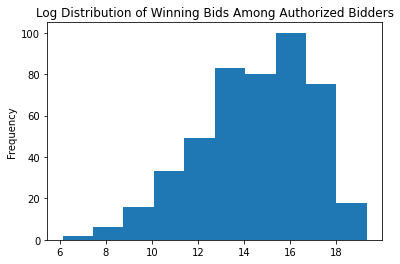

In [296]:
log_bid_histplot = (np.log(authorized[winningBids])
                    .plot(kind = "hist", 
                    title = "Log Distribution of Winning Bids Among Authorized Bidders"))

#### Authorized Maximum Winning Bid by State

In [342]:
authorized_max_bid_by_state = (authorized
                    .groupby(["State"])[winningBids].max()
                    .sort_values(ascending = False)
                    .to_frame()
                    .rename({winningBids: "Maxium Winning Bid"}, axis=1))
authorized_max_bid_by_state.head()


,Maxium Winning Bid
State,
West Virginia,247538077.6
Illinois,193002274.8
Michigan,187669124.0
Texas,186026308.8
Wisconsin,163258003.6


#### Authorized Total Winning Bids by State

In [341]:
authorized_total_bid_by_state = (authorized
                                .groupby("State")[winningBids].sum()
                                .sort_values(ascending=False)
                                .to_frame()
                                .rename({winningBids: "Total Winning Bids"}, axis=1))
                                
authorized_total_bid_by_state.head()

,Total Winning Bids
State,
Mississippi,427972359.6
Arkansas,404126416.4
Michigan,352581490.6
West Virginia,347737683.4
Texas,317974011.9


#### Authorized Locations by State

In [303]:
authorized_locations_by_state = (authorized
                        .groupby("State")["Number of Locations"].sum()
                        .sort_values(ascending=False)
                        .to_frame())

authorized_locations_by_state.head()

,Number of Locations
State,
Texas,280401
Michigan,240796
Arkansas,179025
Mississippi,173219
Wisconsin,149392


---
### Cleaning & Exploratory on `defaults` + Finding Starlink Long-Form Applications

In [343]:
defaults = defaults.rename({"Document":"DA Numbers"}, axis=1)

defaults.head()

,Applicant Name,Winning Bid Name,State,County,Census Block,DA Numbers
0,"4 IP Technology and Media, LLC",TX-053-9605001,Texas,Burnet,480539605001093,DA-22-96
1,AB Indiana LLC,FL-021-0112021,Florida,Collier,120210112021071,DA-22-848
2,AB Indiana LLC,FL-021-0112021,Florida,Collier,120210112021072,DA-22-848
3,AB Indiana LLC,FL-021-0112021,Florida,Collier,120210112021089,DA-22-848
4,AB Indiana LLC,FL-021-0112021,Florida,Collier,120210112021097,DA-22-848


#### Selecting Only Defaults for Starlink

In [344]:
starlink_defaults = (defaults[defaults['Applicant Name']
                    .str
                    .contains("Star")])

'''
One-time save to csv for Starlink defaults
starlink_defaults.to_csv("data/created_data/starlink_defaults.csv", index=False)
'''

starlink_defaults.head()

,Applicant Name,Winning Bid Name,State,County,Census Block,DA Numbers
145689,"Starlink Services, LLC",AL-001-0207001,Alabama,Autauga,10010207001071,DA-22-848
145690,"Starlink Services, LLC",AL-001-0207001,Alabama,Autauga,10010207001073,DA-22-848
145691,"Starlink Services, LLC",AL-001-0207001,Alabama,Autauga,10010207001095,DA-22-848
145692,"Starlink Services, LLC",AL-001-0208011,Alabama,Autauga,10010208011010,DA-22-848
145693,"Starlink Services, LLC",AL-001-0208011,Alabama,Autauga,10010208011017,DA-22-848


In [345]:
# Starlink dataframe simplified
starlink_defaults_cleaned = (starlink_defaults.value_counts()
                            .to_frame()
                            .drop(0, axis=1))

starlink_defaults_cleaned.head()

Empty DataFrame
Columns: []
Index: [(Starlink Services, LLC, AL-001-0207001, Alabama, Autauga, 10010207001071, DA-22-848), (Starlink Services, LLC, PA-003-4070012, Pennsylvania, Allegheny, 420034070012005, DA-22-848), (Starlink Services, LLC, PA-003-4070023, Pennsylvania, Allegheny, 420034070023019, DA-22-848), (Starlink Services, LLC, PA-003-4070022, Pennsylvania, Allegheny, 420034070022027, DA-22-848), (Starlink Services, LLC, PA-003-4070022, Pennsylvania, Allegheny, 420034070022025, DA-22-848)]

#### Plotting Distribution of Census Block Codes Between All Bidders and Starlink

In [ ]:
# Set figure and axes for plotting initial trends on defaults data
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

defaults.plot(ax = axes[0], kind = "hist", title = "Distribution of Census Block Codes")
defaults.plot(ax = axes[1], kind = "hist", title = "Distribution of Census Block Codes")

# Plotting census block distributions for starlink bids
starlink_defaults.plot(ax = axes[1], kind = "hist")

# Setting legend for 
plt.legend(['All Bidders', "Starlink"])

plt.show()

### Merging `authorized` with `defaults`

In [ ]:
authorized.head()

In [ ]:
starlink_defaults.head()

In [346]:
authorized.merge(starlink_defaults, on="DA Numbers")

,Applicant Name_x,FRN,State_x,SAC,Total Winning Bid (over 10 Years),Number of Locations,Winning Bidder,DA Numbers,Applicant Name_y,Winning Bid Name,State_y,County,Census Block


### Cleaning & Exploratory on `ready` + Finding Systematic Differences between `ready` and `authorized` 

In [ ]:
ready.head()

In [ ]:
ready = (ready.rename({"Total Support Amount\n(over 10 years)": 
                    "Total Support (Over 10 years)"}, axis = 1)
                    .sort_values(["Total Locations", "Total Support (Over 10 years)"], ascending = False))
                    
if 462 in ready.index: ready = ready.drop(462, axis=0)

ready.head()

In [339]:
%whos

Variable                         Type           Data/Info
---------------------------------------------------------
FRN_by_state                     DataFrame                               <...>n\n[382 rows x 1 columns]
KNNImputer                       type           <class 'sklearn.impute._knn.KNNImputer'>
LinearRegression                 ABCMeta        <class 'sklearn.linear_mo<...>._base.LinearRegression'>
MinMaxScaler                     type           <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
OneHotEncoder                    type           <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
SimpleImputer                    type           <class 'sklearn.impute._base.SimpleImputer'>
StandardScaler                   type           <class 'sklearn.preproces<...>ng._data.StandardScaler'>
authorized                       DataFrame                             Ap<...>n\n[462 rows x 8 columns]
authorized_FRN_by_state          DataFrame                               <...>